**Name:Sai Navyanth VOBBILISETTY, Charan Kumar Raju RUDRARAJU** 

**EID:svobbilis2, crudraraj2** 

**Kaggle Team Name:CnN** 

# CS4487 - Course Project: Aerial Cactus Identification

## Goal
In this project, your goal is to train a classifier to predict whether an input image contains cactus.


## Methodology
You need to train classifiers using the training data, and then predict on the test data. You are free to choose the feature extraction method and classifier algorithm.  You are free to use methods that were not introduced in class.  You should probably do cross-validation to select a good parameters.


## Evaluation on Kaggle

You need to submit your test predictions to Kaggle for evaluation.  50% of the test data will be used to show your ranking on the live leaderboard.  After the assignment deadline, the remaining 50% will be used to calculate your final ranking. 

To submit to Kaggle you need to create an account, and use the competition invitation that will be posted on Canvas.

**Note:** You can only submit 2 times per day to Kaggle!



## Kaggle Notebooks

You can use Kaggle notebooks to run your code. This ipynb has also been uploaded to the Kaggle competition site. 

# Installing nbextensions for formatting jupyter notebook

In [ ]:
# if you haven't installed the extensions then please install them by the command
pip install jupyter_contrib_nbextensions && jupyter contrib nbextension install 

    Please follow the instructions given in this website
https://towardsdatascience.com/jupyter-notebook-extensions-517fa69d2231
    to get the extensions. After installing the extensions, to enable the extensions, go to the Nbextensions tab and select the extensions required. These are the extensions we used:
   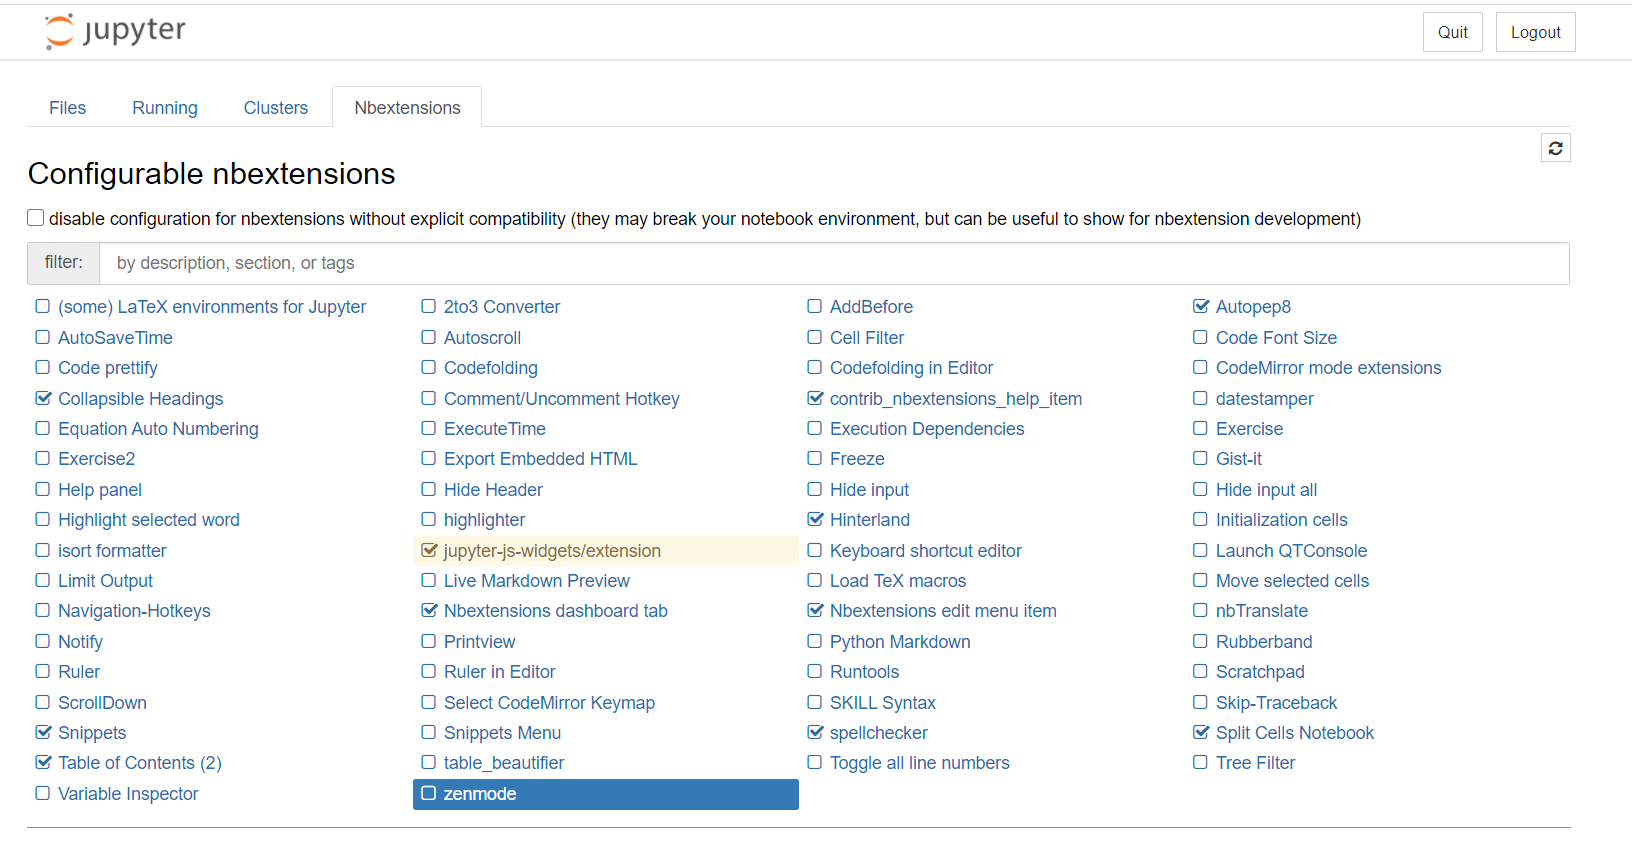

If this is the first time, you are installing these extensions, then please restart jupyter to get the extensions right.

# Loading the Data

The class labels `"1"` for images containing cactus and `"0"` for others.

To submit to Kaggle, you need to generate a Kaggle submission files, which is CSV file with the following format. `'id'` is the file name of the input image: 

<pre>
Id,Prediction
cactus_0181_18.jpg,1
Sinplanta.4365.jpg,0
...
</pre>

First import all the required libraries and here are two helpful functions for reading the data and writing the Kaggle submission file.

In [2]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from glob import glob
from scipy import stats
import csv
random.seed(100)
import os
from tqdm import tqdm, tqdm_notebook
from keras.models import Sequential,Model
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.applications import VGG16
from keras.optimizers import Adam,RMSprop
import cv2
from keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import Image
from keras.preprocessing import image
from keras import optimizers
from keras import layers,models
from keras.applications.imagenet_utils import preprocess_input
import seaborn as sns
from keras import regularizers
import numpy as np
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint,LearningRateScheduler
from keras.layers import Input,InputLayer, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D

In [3]:
def read_train_data():
    cactus_imgs = glob("training_set/training_set/cactus/*")
    cactus_labels = ones(len(cactus_imgs), dtype=int)
    nocactus_imgs = glob("training_set/training_set/no_cactus/*")
    nocactus_labels = zeros(len(nocactus_imgs), dtype=int)

    train_X = cactus_imgs + nocactus_imgs
    train_Y = hstack((cactus_labels, nocactus_labels))
    return train_X, train_Y

def read_test_data():
    return glob("validation_set/*/*/*")

def write_csv_kaggle_sub(fname, X, Y):
    # fname = file name
    # X is a list with image names
    # Y is a list/array with class entries
    
    # header
    tmp = [['Id', 'Prediction']]
    
    # add ID numbers for each Y
    for x,y in zip(X, Y):
        tmp2 = [x, y]
        tmp.append(tmp2)
        
    # write CSV file
    with open(fname, 'w') as f:
        writer = csv.writer(f)
        writer.writerows(tmp)

In [4]:
train_X, train_Y = read_train_data()
print(train_X[0], train_Y[0])
print(train_X[15000], train_Y[15000])

test_X = read_test_data()
print(len(test_X))
print(os.path.basename(test_X[0]))

training_set/training_set/cactus\cactus_0028_0.jpg 1
training_set/training_set/no_cactus\Sinplanta.2677.jpg 0
4000
cactus_0181_18.jpg


# Pre Processing

### We use numpy to load all the images as train_set and test_set

In [16]:
#we resize the images, and normalize all images by dividing by 255 so that all pixel values are between 0-1
#train_set here contains all the images as a list

train_set = []
for num in range(17500):
    if num%1000==0:
        print(num)
    img_path = train_X[num]
    img= cv2.imread(img_path)
    img = cv2.resize(img,(150,150))
    img = np.asarray(img)
    #img = np.expand_dims(img, axis=0)
    img = img/255
    train_set.append(img)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000


In [17]:
#we convert the list into a numpy array
train_set = np.asarray(train_set)

In [19]:
#we do the same steps for the test set as well.
test_set = []
for num in range(len(test_X)):
    img_path = test_X[num]
    img= cv2.imread(img_path)
    img = cv2.resize(img,(150,150))
    img = np.asarray(img)
    #img = np.expand_dims(img, axis=0)
    img = img/255
    test_set.append(img)

In [20]:
#convert the test_set list as an array
test_set = np.asarray(test_set)

### Displaying some images of cactus and without cactus

In [65]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=10):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)
    
    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(X[i])
    
    # add blanks
    if (numimgs > maxw) and (mod(numimgs, maxw) > 0):
        leftover = maxw - mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)
    
    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( hstack(tmp[i:i+maxw]) )
    montimg = vstack(tmp2) 
    return montimg

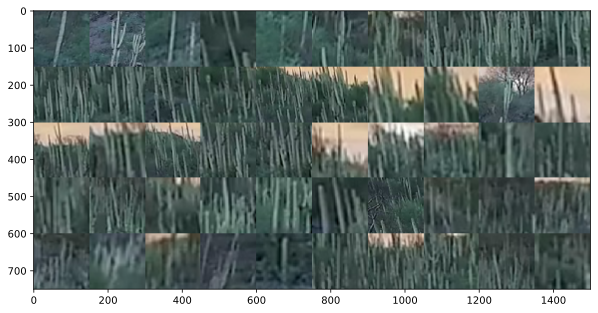

In [70]:
plt.figure(figsize=(10,10))
plt.imshow(image_montage(train_set[:50]), cmap='gray', interpolation='nearest')
plt.show()

Here we can see that almost all the images of cactus are vertical

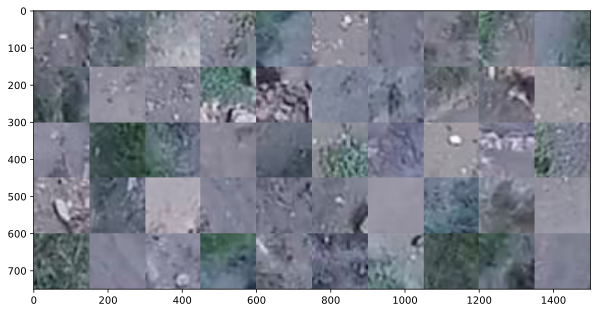

In [71]:
plt.figure(figsize=(10,10))
plt.imshow(image_montage(train_set[-50:]), cmap='gray', interpolation='nearest')
plt.show()

### We split the train set into train and validation set

In [18]:
#we stratify on the train_y so that the classvalues are proportional in both the sets
train_set1,val_set,trY,valY = train_test_split(train_set,train_Y,stratify=train_Y)

### Using Image generators/ Image Augumentation

In [6]:
#we used image generators also
from keras.preprocessing.image import ImageDataGenerator

#we have used image augumentation by using different methods like rotation_range, width_shift, etc 
#this is because, the images are taken in different angles, so augumenting it would give us a better perspective

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# this is a generator that will read pictures found in
# subfolers of 'training_set/training_set', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'training_set/training_set/',  # this is the target directory
        target_size=(150, 150),  # all images will be resized to 150x150
        batch_size=32,
        class_mode='binary') 

Found 17500 images belonging to 2 classes.


In [7]:
#code to get the images from testing directory
test_generator = train_datagen.flow_from_directory(
    'validation_set/validation_set',
    target_size=(150, 150),  # all images will be resized to 150x150
    batch_size=32,
    class_mode='binary'
)

Found 4000 images belonging to 2 classes.


# Method 1 - CNN with Batch Normalization

Though we have learned lot of algorithms in the course like logistic regression,support vector machines, etc. our group decided to chose Convolutional Neural Networks for our project for various reasons:
<ol>
 <li> In the traditional algorithms, we need to extract features and then give those features to the model. So, that's a tedious task, cause the feature extraction algorithms like SIFT, ORB, etc are not that efficient and won't give us better results.</li>
 <li> But, from 2012, Alexnet became famous, which is a CNN used for image classification and won the Imagenet Competition that year.</li>
 <li> The major advantage of using CNN over (feature extraction + traditional algorithms) is that CNN computes features and then classifies images in the same network itself. </li>
 <li> So, we don't have to split the problem into two steps and then work on fine tuning both the steps. We have to work on fine tuning only one whole network if we use CNNs.</li>
</ol>
These are the reasons why we chose to use CNNs for our project. 
The first model we used is a CNN with 4 hidden layers with batch normalizations, max pooling, ReLU activation functions for the hidden layers and 2 dense layers with dropouts in the end.

So, in a CNN it learns features and classifies in the same step itself.
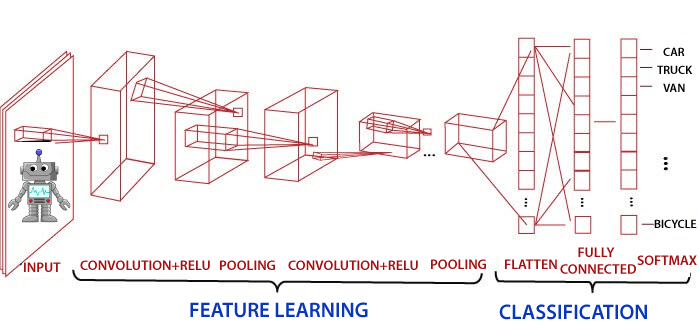

#### In the first architecture, we have used a CNN with 4 convolutional layers with max pooling and batch normalization.

We are using batch normalization cause we normalized inputs given to the input layer. So,in the similar way, we need to normalize the outputs of a layer before sending to the activation function, so that the inputs to the hidden layer are also normalized.
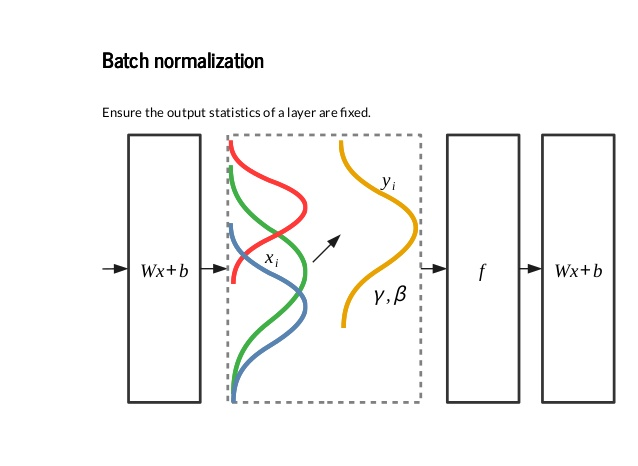

In [10]:
inputShape=(150,150,3)
input = Input(inputShape)

x = Conv2D(64,(3,3),strides = (1,1),name='layer_conv1',padding='same')(input)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2),name='maxPool1')(x)



x = Conv2D(64,(3,3),strides = (1,1),name='layer_conv2',padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2),name='maxPool2')(x)

x = Conv2D(32,(3,3),strides = (1,1),name='conv3',padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2),name='maxPool3')(x)

x = Conv2D(32,(3,3),strides = (1,1),name='conv4',padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D((2,2),name='maxPool4')(x)

x = Flatten()(x)
x = Dense(64,activation = 'relu',name='fc0')(x)
x = Dropout(0.25)(x)
x = Dense(32,activation = 'relu',name='fc1')(x)
x = Dropout(0.25)(x)
x = Dense(1,activation = 'sigmoid',name='fc2')(x)

model_batch = Model(inputs = input,outputs = x,name='Predict')

In [11]:
model_batch.summary()

Model: "Predict"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 150, 150, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 150, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 150, 150, 64)      0         
_________________________________________________________________
maxPool1 (MaxPooling2D)      (None, 75, 75, 64)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 75, 75, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 64)        256 

#### We have used many parameters and trained our model. We trained our model with different learning rates and different optimizers like 'adam', 'stochasic gradient descent (sgd)', 'RMSprop', etc. We are keeping the best performing combination of learning rate and optimizer for the sake of the report.

In [12]:
model_batch.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])

#### We fit the model with the numpy arrays of images we created during the preprocessing step.

In [14]:
epochs=10
history_batch=model_batch.fit(train_set1,trY,epochs=10,batch_size = 32,validation_data=(val_set,valY))

Epoch 1/10
411/411 [==============================] - 1103s 3s/step - loss: 0.3902 - accuracy: 0.8187 - val_loss: 0.7434 - val_accuracy: 0.4464
Epoch 2/10
411/411 [==============================] - 1080s 3s/step - loss: 0.2006 - accuracy: 0.9269 - val_loss: 0.1412 - val_accuracy: 0.9463
Epoch 3/10
411/411 [==============================] - 2191s 5s/step - loss: 0.1655 - accuracy: 0.9394 - val_loss: 0.1095 - val_accuracy: 0.9573
Epoch 4/10
411/411 [==============================] - 590s 1s/step - loss: 0.1451 - accuracy: 0.9463 - val_loss: 0.0955 - val_accuracy: 0.9666
Epoch 5/10
411/411 [==============================] - 549s 1s/step - loss: 0.1275 - accuracy: 0.9535 - val_loss: 0.0869 - val_accuracy: 0.9689
Epoch 6/10
411/411 [==============================] - 580s 1s/step - loss: 0.1161 - accuracy: 0.9593 - val_loss: 0.0830 - val_accuracy: 0.9689
Epoch 7/10
411/411 [==============================] - 602s 1s/step - loss: 0.1069 - accuracy: 0.9624 - val_loss: 0.0787 - val_accuracy: 0.9

#### Now visualizations of the accuracies and the loss

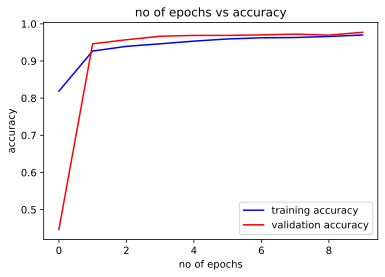

In [15]:
acc=history_batch.history['accuracy']  ##getting  accuracy of each epochs
acc_val=history_batch.history['val_accuracy']  ##getting validation accuracy of each epochs
epochs_=range(0,10)  
plt.plot(epochs_,acc,color='blue',label='training accuracy')
plt.plot(epochs_,acc_val,color='red',label='validation accuracy')
plt.xlabel('no of epochs')
plt.ylabel('accuracy')

plt.title("no of epochs vs accuracy")
plt.legend()

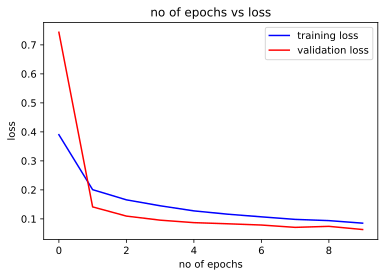

In [16]:
loss=history_batch.history['loss']  ##getting  accuracy of each epochs
loss_val=history_batch.history['val_loss']  ##getting validation accuracy of each epochs
epochs_=range(0,10)  
plt.plot(epochs_,loss,color='blue',label='training loss')
plt.plot(epochs_,loss_val,color='red',label='validation loss')
plt.xlabel('no of epochs')
plt.ylabel('loss')

plt.title("no of epochs vs loss")
plt.legend()

As we can see above, the validation loss has been steadily decreasing over the epochs, and the validation accuracy has been steadily increasing over the epochs, which says that our model is not overfitting.
Our model after the 10th epoch gave us a validation accuracy of 97.74 and training accuracy of 97.00

#### Now, we tested the model on the test set

In [55]:
preds = model_batch.predict(train_set1)

preds_classes = []
for x in preds:
    if x>0.5:
        preds_classes.append(1)
    else:
        preds_classes.append(0)

In [25]:
#preds = [x[0] for x in preds]
dummy_test_X = [os.path.basename(x) for x in test_X]

write_csv_kaggle_sub("my_submission_batch_norm_2.csv", dummy_test_X, preds_classes)

Our accuracy for this test set was <b>95.6</b> which is not that great. So, we tried using a different architecture.

# Method-2 Training with different CNN architecture 

#### This architecture is similar to the previous one, but we added initializers like 'he_uniform' which initializes the weights and biases of our network which would reduce the number of epochs required to get a better accuracy or even increase the accuracy.

In this method, the weights are initialized keeping in mind the size of the previous layer which helps in attaining a global minimum of the cost function faster and more efficiently.The weights are still random but differ in range depending on the size of the previous layer of neurons. This provides a controlled initialization hence the faster and more efficient gradient descent.
-https://prateekvishnu.medium.com/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528


According to the research paper https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf
he_uniform initialization converges better than the xavier initialization. That is why we chose he_uniform over xavier.
But we ran our model even with Xavier initialization, unfortunately, the results were not better. So, we stuck with he_uniform initialization itself for this report.
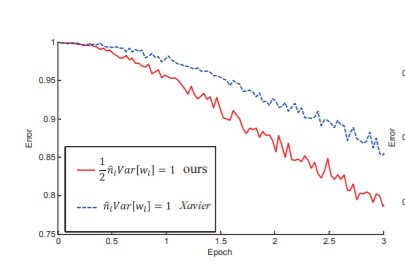

In this architecture as well, we have used 4 convolutional layers with maxpooling and batch normalization.

In [72]:
batch_normalization = True
model = Sequential()
model.add(Conv2D(32, 3, activation = 'relu', padding = 'same', input_shape = (150, 150, 3)))
if batch_normalization: model.add(BatchNormalization())
    
model.add(Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform'))
if batch_normalization: model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform'))
if batch_normalization: model.add(BatchNormalization())
    
model.add(Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform'))
if batch_normalization: model.add(BatchNormalization()) 
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128, activation = 'relu', kernel_initializer = 'he_uniform'))
model.add(Dense(1, activation = 'sigmoid'))

In [73]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 75, 75, 64)       

In this architecture as well, we have ran our model with different learning rates and optimizers, and kept the results which gave us the best outputs. 

In [85]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-5), 
              metrics=['accuracy'])

In [86]:
epochs=10
history1=model.fit(train_set1,trY,epochs=10,batch_size = 32,validation_data=(val_set,valY))

Epoch 1/10
411/411 [==============================] - 3808s 9s/step - loss: 31.4673 - accuracy: 0.8851 - val_loss: 34.7537 - val_accuracy: 0.2496
Epoch 2/10
411/411 [==============================] - 3231s 8s/step - loss: 29.6345 - accuracy: 0.9362 - val_loss: 28.7190 - val_accuracy: 0.9488
Epoch 3/10
411/411 [==============================] - 2823s 7s/step - loss: 27.9037 - accuracy: 0.9445 - val_loss: 27.0388 - val_accuracy: 0.9634
Epoch 4/10
411/411 [==============================] - 2826s 7s/step - loss: 26.2793 - accuracy: 0.9518 - val_loss: 25.4854 - val_accuracy: 0.9662
Epoch 5/10
411/411 [==============================] - 2831s 7s/step - loss: 24.7776 - accuracy: 0.9609 - val_loss: 24.0424 - val_accuracy: 0.9678
Epoch 6/10
411/411 [==============================] - 2831s 7s/step - loss: 23.4013 - accuracy: 0.9611 - val_loss: 22.7243 - val_accuracy: 0.9687
Epoch 7/10
411/411 [==============================] - 2815s 7s/step - loss: 22.1101 - accuracy: 0.9649 - val_loss: 21.4945 -

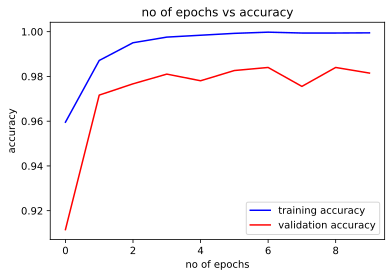

In [22]:
acc=history1.history['accuracy']  ##getting  accuracy of each epochs
acc_val=history1.history['val_accuracy']  ##getting validation accuracy of each epochs
epochs_=range(0,10)  
plt.plot(epochs_,acc,color='blue',label='training accuracy')
plt.plot(epochs_,acc_val,color='red',label='validation accuracy')
plt.xlabel('no of epochs')
plt.ylabel('accuracy')

plt.title("no of epochs vs accuracy")
plt.legend()

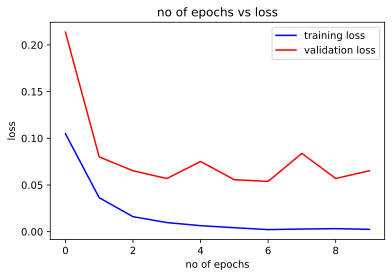

In [23]:
loss=history1.history['loss']  ##getting  accuracy of each epochs
loss_val=history1.history['val_loss']  ##getting validation accuracy of each epochs
epochs_=range(0,10)  
plt.plot(epochs_,loss,color='blue',label='training loss')
plt.plot(epochs_,loss_val,color='red',label='validation loss')
plt.xlabel('no of epochs')
plt.ylabel('loss')

plt.title("no of epochs vs loss")
plt.legend()

As we can see above, the validation loss has been steadily decreasing over the epochs, and the validation accuracy has been steadily increasing over the epochs, which says that our model is not overfitting.
Our model after the 10th epoch gave us a validation accuracy of 97.35 and training accuracy of 97.27

This is the confusion matrix for the validation set:

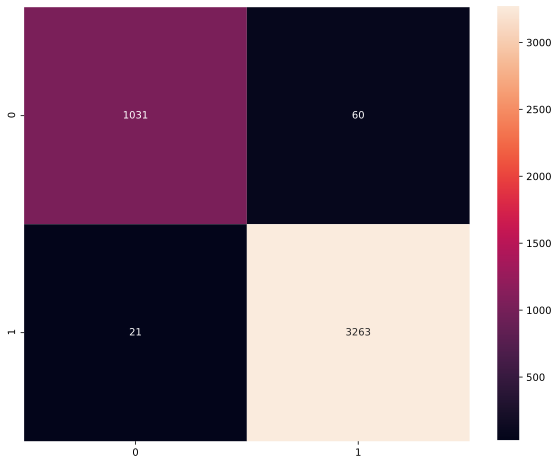

In [36]:
from sklearn.metrics import confusion_matrix

# compute the confusion matrix
confusion_mtx = confusion_matrix(valY, ped)

plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt="d");

In [56]:
#this is the code to check what the layers are representing!
#we are testing on the 10th image of the training set, which is an image of a cactus
from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(train_set[10].reshape(1,150,150,3))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

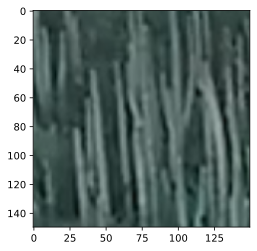

In [74]:
#this is the image
plt.imshow(train_set[10]);

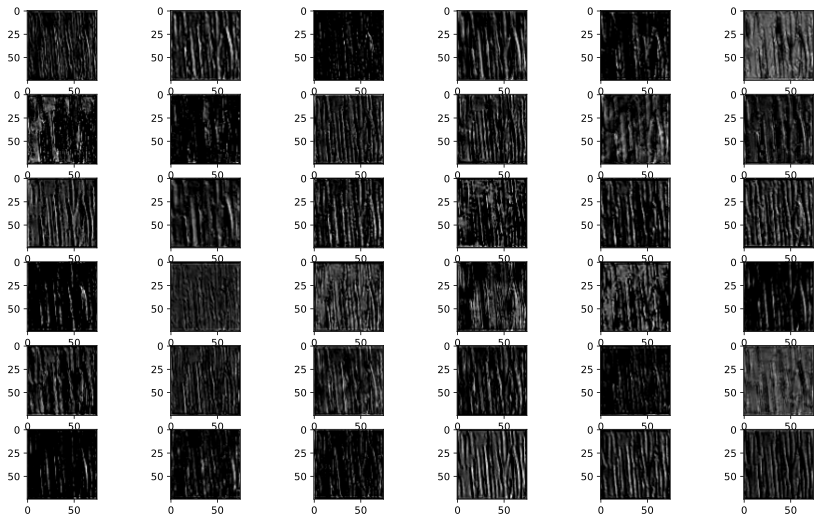

In [61]:
#this is what the layers represent
display_activation(activations, 6, 6, 7)

#### Predict on test set

In [32]:
preds = model.predict_classes(test_set)
preds = [x[0] for x in preds]
dummy_test_X = [os.path.basename(x) for x in test_X]

write_csv_kaggle_sub("my_submission.csv", dummy_test_X, preds)

The accuracy we got with this test set was <b>97.8</b>, when we submitted it in kaggle

# Method 3 - Transfer Learning

Lastly, we have used Transfer learning trying to improve the accuracy more.

#### About the Imagenet Competition

ImageNet is a dataset of over 15 million labeled high-resolution images belonging to roughly 22,000 categories. The images were collected from the web and labeled by human labelers using Amazon’s Mechanical Turk crowd-sourcing tool. Starting in 2010, as part of the Pascal Visual Object Challenge, an annual competition called the ImageNet Large-Scale Visual Recognition Challenge (ILSVRC) has been held. ILSVRC uses a subset of ImageNet with roughly 1000 images in each of 1000 categories. In all, there are roughly 1.2 million training images, 50,000 validation images, and 150,000 testing images.


In 2012, AlexNet won the challenge using CNNs, and that's when the deep learning revolution begun. Thereafter, every year, the error rate kept decreasing:
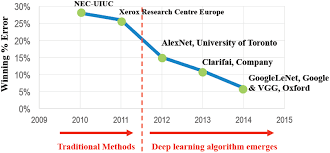

#### About the VGG Network

The network was submitted to the imagenet classification competition which is held every year. This network was submitted on 2014 and gained an accuracy of 92% on the test set.

The network has 16 weight layers. We have used only the convulutional layers to get the features and excluded the top dense layers and added our own layers to it.
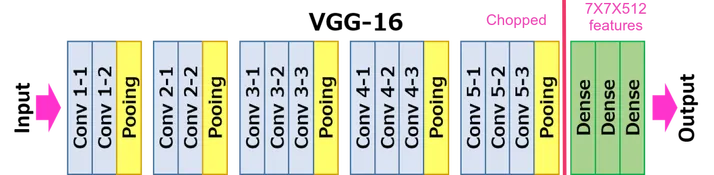

In [8]:
vgg16_net = VGG16(weights='imagenet', 
                  include_top=False, 
                  input_shape=(150, 150, 3))

In [9]:
vgg16_net.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

We froze the first 15 layers of the network and added our layers in the end, and fine tuned our model to improve accuracy.

In [10]:

i=0
for lay in vgg16_net.layers[:15]:
    lay.trainable=False
    i+=1
print(i)
    

15


#### We added our own layers to the end of the VGG layers

In [21]:
model_vgg = Sequential()
model_vgg.add(vgg16_net)
#model_vgg.add(Flatten())
model_vgg.add(Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform'))
model_vgg.add(BatchNormalization())
model_vgg.add(Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_uniform'))
model_vgg.add(BatchNormalization()) 
model_vgg.add(MaxPooling2D())
model_vgg.add(Flatten())
model_vgg.add(Dense(128, activation = 'relu', kernel_initializer = 'he_uniform'))
model_vgg.add(Dense(1, activation = 'sigmoid'))
model_vgg.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])

Even here, we have tried with different parameters like the learning rate, optimizer function, and kept the one's which gave the best outputs.

In [22]:
model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          294976    
_________________________________________________________________
batch_normalization_2 (Batch (None, 4, 4, 64)          256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, 4, 4, 64)          256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)              

#### We used the callbacks function this time, so that the model can stop after reaching a certain validation accuracy

In [27]:
import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        ACCURACY_THRESHOLD=0.9999
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True
callback = myCallback()

In [28]:
%%time
epochs=50
history_vgg=model_vgg.fit(train_set1,trY,epochs=epochs,validation_data=(val_set,valY),callbacks=callback)

Epoch 1/20
411/411 [==============================] - 1518s 4s/step - loss: 0.0142 - accuracy: 0.9961 - val_loss: 0.0269 - val_accuracy: 0.9906
Epoch 2/20
411/411 [==============================] - 1474s 4s/step - loss: 0.0087 - accuracy: 0.9981 - val_loss: 0.0239 - val_accuracy: 0.9922
Epoch 3/20
411/411 [==============================] - 1487s 4s/step - loss: 0.0048 - accuracy: 0.9992 - val_loss: 0.0263 - val_accuracy: 0.9909
Epoch 4/20
411/411 [==============================] - 1497s 4s/step - loss: 0.0098 - accuracy: 0.9977 - val_loss: 0.0252 - val_accuracy: 0.9913
Epoch 5/20
411/411 [==============================] - 1505s 4s/step - loss: 0.0031 - accuracy: 0.9996 - val_loss: 0.0436 - val_accuracy: 0.9861
Epoch 6/20
411/411 [==============================] - 1456s 4s/step - loss: 0.0014 - accuracy: 0.9999 - val_loss: 0.0242 - val_accuracy: 0.9920
Epoch 7/20
411/411 [==============================] - 1411s 3s/step - loss: 6.5181e-04 - accuracy: 1.0000 - val_loss: 0.0246 - val_accur

#### Visualization of results

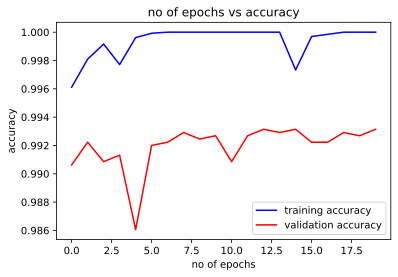

In [30]:
acc=history_vgg.history['accuracy']  ##getting  accuracy of each epochs
acc_val=history_vgg.history['val_accuracy']  ##getting validation accuracy of each epochs
epochs_=range(0,50)  
plt.plot(epochs_,acc,color='blue',label='training accuracy')
plt.plot(epochs_,acc_val,color='red',label='validation accuracy')
plt.xlabel('no of epochs')
plt.ylabel('accuracy')

plt.title("no of epochs vs accuracy")
plt.legend()

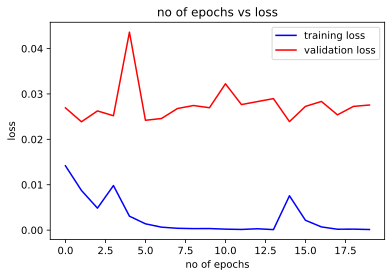

In [31]:
loss=history_vgg.history['loss']  ##getting  accuracy of each epochs
loss_val=history_vgg.history['val_loss']  ##getting validation accuracy of each epochs
epochs_=range(0,50)  
plt.plot(epochs_,loss,color='blue',label='training loss')
plt.plot(epochs_,loss_val,color='red',label='validation loss')
plt.xlabel('no of epochs')
plt.ylabel('loss')

plt.title("no of epochs vs loss")
plt.legend()

As we can see here, the validation loss is steady and not increasing after the 5th epoch, which means that there is no overfitting issue here. Our validation accuracy after 20th epoch is <b>99.31%</b>

#### Analysis on the new test set

In [32]:
#we predict on the test set
preds = np.argmax(model_vgg.predict(test_set), axis=-1)

In [54]:
#check the indices of the images where the images are classified as having cactus, when they should be classifed 
#as not having cactus
preds_neg = preds[-1000:]
vnt = []
for i in range(len(preds_neg)):
    if preds_neg[i]==1:
        vnt.append(i)
vnt

[152, 171, 356, 505, 606, 735, 879]

#### Helper function to view images as a montage

In [55]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=10):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)
    
    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(X[i])
    
    # add blanks
    if (numimgs > maxw) and (mod(numimgs, maxw) > 0):
        leftover = maxw - mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)
    
    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( hstack(tmp[i:i+maxw]) )
    montimg = vstack(tmp2) 
    return montimg

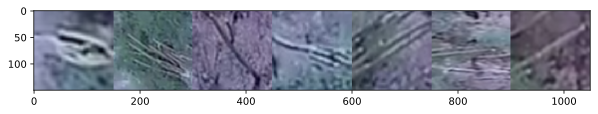

In [60]:
plt.figure(figsize=(10,10))
plt.imshow(image_montage(test_set[vnt]), cmap='gray', interpolation='nearest')
plt.show()

For the above images the model classified them to have cactus, but according to the true labels they do not contain cactus. We can see here that, the images look like they have cactus even to our eyes.

In [61]:
preds_neg = preds[:3000]
vnt_pos = []
for i in range(len(preds_neg)):
    if preds_neg[i]==0:
        vnt_pos.append(i)
vnt_pos

[31,
 143,
 157,
 172,
 180,
 182,
 190,
 192,
 197,
 199,
 206,
 208,
 220,
 225,
 228,
 240,
 244,
 252,
 263,
 276,
 282,
 312,
 325,
 352,
 369,
 384,
 464,
 469,
 474,
 520,
 538,
 597,
 598,
 614,
 701,
 1030,
 1036,
 1037,
 1336,
 1474,
 1630,
 1689,
 2030,
 2117,
 2174,
 2248,
 2340,
 2368,
 2422,
 2531,
 2727,
 2765,
 2826,
 2829,
 2875,
 2982,
 2985,
 2988]

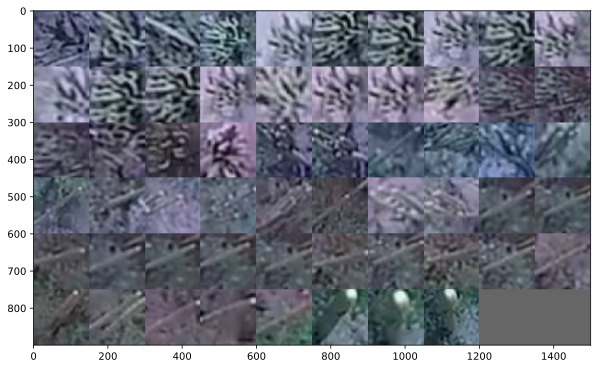

In [62]:
plt.figure(figsize=(10,10))
plt.imshow(image_montage(test_set[vnt_pos]), cmap='gray', interpolation='nearest')
plt.show()

The model classifies the above images as having no cactus in them. But according to the true labels, these images contain cactus.

In [64]:
preds = [x[0] for x in preds]
dummy_test_X = [os.path.basename(x) for x in test_X]

write_csv_kaggle_sub("my_submission_vgg.csv", dummy_test_X, preds)

The accuracy on the test set came out to be <b>98.5%</b> when we submitted on kaggle.

# Method 4 - Transfer Learning (Res- Net)

#### About the ResNet

Residual Network (ResNet) is a Convolutional Neural Network (CNN)  architecture which was designed to enable hundreds or thousands of convolutional layers. While previous CNN architectures had a drop off in the effectiveness of additional layers, ResNet can add a large number of layers with strong performance.<br>
The ResNet solution is “identity shortcut connections”. ResNet stacks up identity mappings, layers that initially don’t do anything, and skips over them, reusing the activations from previous layers. Skipping initially compresses the network into only a few layers, which enables faster learning. Then, when the network trains again, all layers are expanded and the “residual” parts of the network explore more and more of the feature space of the source image.

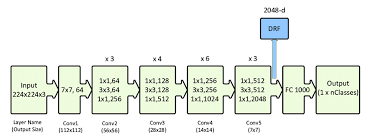

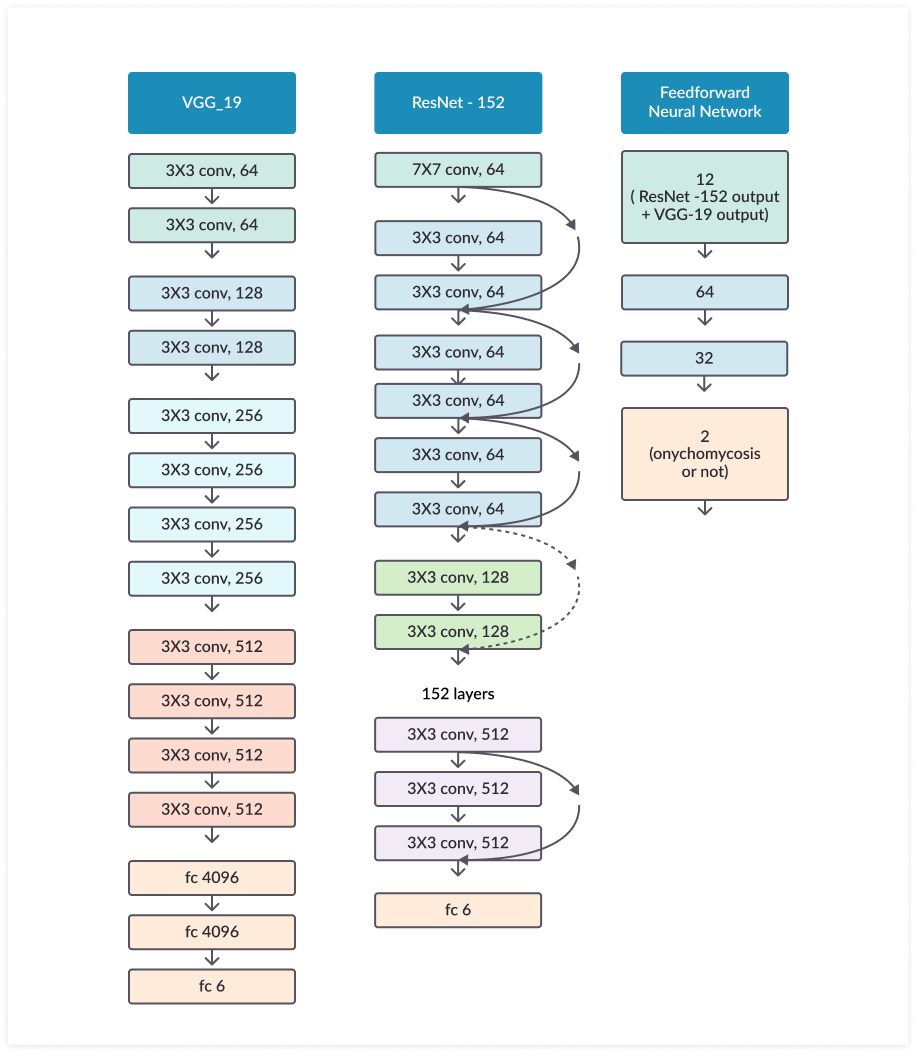

In [36]:
from keras.applications.resnet50 import ResNet50
res_net = ResNet50(weights='imagenet', include_top =False,
                    input_shape = (150,150,3))

In [13]:
res_net.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

#### Adding our own layers to the end of the ResNet

In [37]:
model_vgg = Sequential()
model_vgg.add(res_net)
#model_vgg.add(Flatten())
model_vgg.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_uniform'))
model_vgg.add(BatchNormalization())
model_vgg.add(Activation('relu'))
model_vgg.add(MaxPooling2D())

model_vgg.add(Conv2D(32, 3, padding = 'same', kernel_initializer = 'he_uniform'))
model_vgg.add(BatchNormalization()) 
model_vgg.add(Activation('relu'))
model_vgg.add(MaxPooling2D())

model_vgg.add(Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_uniform'))
model_vgg.add(BatchNormalization()) 
model_vgg.add(Activation('relu'))
#model_vgg.add(MaxPooling2D())

model_vgg.add(Flatten())
model_vgg.add(Dense(32, activation = 'relu', kernel_initializer = 'he_uniform'))
model_vgg.add(Dense(1, activation = 'sigmoid'))
model_vgg.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=1e-5), 
              metrics=['accuracy'])

In [38]:
model_vgg.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 5, 5, 64)          1179712   
_________________________________________________________________
batch_normalization_9 (Batch (None, 5, 5, 64)          256       
_________________________________________________________________
activation_9 (Activation)    (None, 5, 5, 64)          0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 2, 2, 32)          18464     
_________________________________________________________________
batch_normalization_10 (Batc (None, 2, 2, 32)         

In [49]:
import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        ACCURACY_THRESHOLD=0.9999
        if(logs.get('val_accuracy') > ACCURACY_THRESHOLD):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True
callback = myCallback()

#### Running our model for 20 epochs with the above callbacks function

In [40]:
%%time
epochs=20
history_vgg=model_vgg.fit(train_set1,trY,epochs=epochs,validation_data=(val_set,valY),callbacks=callback)

Epoch 1/20
411/411 [==============================] - 769s 2s/step - loss: 0.3384 - accuracy: 0.8853 - val_loss: 3.0997 - val_accuracy: 0.7506
Epoch 2/20
411/411 [==============================] - 756s 2s/step - loss: 0.1528 - accuracy: 0.9823 - val_loss: 1.9070 - val_accuracy: 0.1806
Epoch 3/20
411/411 [==============================] - 758s 2s/step - loss: 0.0921 - accuracy: 0.9918 - val_loss: 0.1362 - val_accuracy: 0.9781
Epoch 4/20
411/411 [==============================] - 758s 2s/step - loss: 0.0615 - accuracy: 0.9938 - val_loss: 0.0552 - val_accuracy: 0.9945
Epoch 5/20
411/411 [==============================] - 764s 2s/step - loss: 0.0438 - accuracy: 0.9959 - val_loss: 0.0387 - val_accuracy: 0.9950
Epoch 6/20
411/411 [==============================] - 762s 2s/step - loss: 0.0322 - accuracy: 0.9970 - val_loss: 0.0270 - val_accuracy: 0.9970
Epoch 7/20
411/411 [==============================] - 761s 2s/step - loss: 0.0252 - accuracy: 0.9976 - val_loss: 0.0216 - val_accuracy: 0.9975

#### Visualization of results

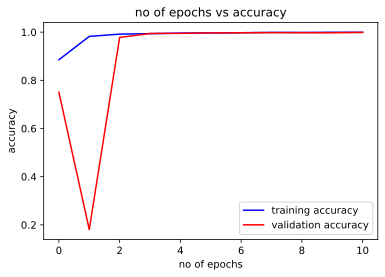

In [42]:
acc=history_vgg.history['accuracy']  ##getting  accuracy of each epochs
acc_val=history_vgg.history['val_accuracy']  ##getting validation accuracy of each epochs
epochs_=range(0,11)  
plt.plot(epochs_,acc,color='blue',label='training accuracy')
plt.plot(epochs_,acc_val,color='red',label='validation accuracy')
plt.xlabel('no of epochs')
plt.ylabel('accuracy')

plt.title("no of epochs vs accuracy")
plt.legend()

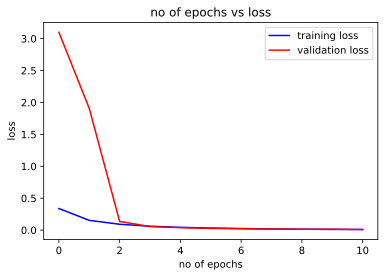

In [43]:
loss=history_vgg.history['loss']  ##getting  accuracy of each epochs
loss_val=history_vgg.history['val_loss']  ##getting validation accuracy of each epochs
epochs_=range(0,11)  
plt.plot(epochs_,loss,color='blue',label='training loss')
plt.plot(epochs_,loss_val,color='red',label='validation loss')
plt.xlabel('no of epochs')
plt.ylabel('loss')

plt.title("no of epochs vs loss")
plt.legend()

As you can see above, the validation accuracy is increasing steadily, and the validation loss is decreasing steadily. So, there is no overfitting at all.

#### Predicting on the test set

In [44]:
preds = model_vgg.predict_classes(test_set)

#### Check for what images the model wrongly classified

In [51]:
#check the indices of the images where the images are classified as having cactus, when they should be classifed 
#as not having cactus
preds_neg = preds[-1000:]
vnt = []
for i in range(len(preds_neg)):
    if preds_neg[i]==1:
        vnt.append(i)
vnt

[849, 897]

In [55]:
preds_neg = preds[:3000]
vnt_pos = []
for i in range(len(preds_neg)):
    if preds_neg[i]==0:
        vnt_pos.append(i)
vnt_pos

[179,
 187,
 199,
 215,
 228,
 258,
 369,
 375,
 390,
 425,
 474,
 500,
 503,
 658,
 2982,
 2985,
 2998]

In [50]:
# function to make an image montage
def image_montage(X, imsize=None, maxw=10):
    """X can be a list of images, or a matrix of vectorized images.
      Specify imsize when X is a matrix."""
    tmp = []
    numimgs = len(X)
    
    # create a list of images (reshape if necessary)
    for i in range(0,numimgs):
        if imsize != None:
            tmp.append(X[i].reshape(imsize))
        else:
            tmp.append(X[i])
    
    # add blanks
    if (numimgs > maxw) and (mod(numimgs, maxw) > 0):
        leftover = maxw - mod(numimgs, maxw)
        meanimg = 0.5*(X[0].max()+X[0].min())
        for i in range(0,leftover):
            tmp.append(ones(tmp[0].shape)*meanimg)
    
    # make the montage
    tmp2 = []
    for i in range(0,len(tmp),maxw):
        tmp2.append( hstack(tmp[i:i+maxw]) )
    montimg = vstack(tmp2) 
    return montimg

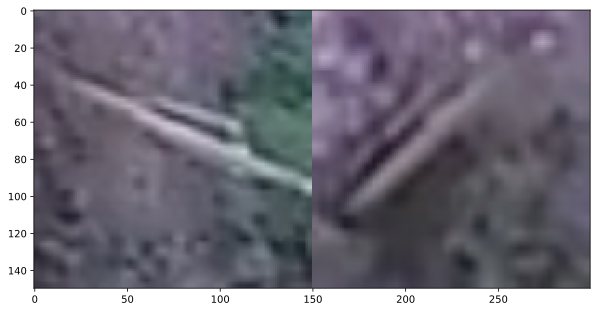

In [53]:
plt.figure(figsize=(10,10))
plt.imshow(image_montage(test_set[vnt]), cmap='gray', interpolation='nearest')
plt.show()

In the above images, the model was suppose to classify them as images containing no cactus, but our model classified it to have cactus. But, as we can see here, there are some vertical lines in the images, which caused the model to predict it as cactus.

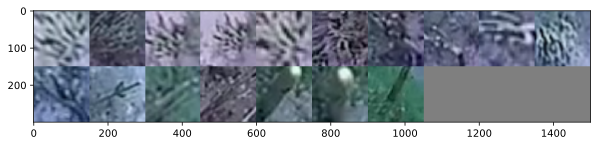

In [54]:
plt.figure(figsize=(10,10))
plt.imshow(image_montage(test_set[vnt_pos]), cmap='gray', interpolation='nearest')
plt.show()

In the above 17 images, the model classifies them as not having cactus, when they actually have cactus. Here, the main reason could be that, almost all the cactus images we have, have only single or 2 vertical cactus. But, here the cactus are like in a bush, which might have confused the model.

The accuracy on the test set came out to be <b>99.7%</b>. This is what we submitted on kaggle

#### Saving the predictions

In [48]:
preds = [x[0] for x in preds]
dummy_test_X = [os.path.basename(x) for x in test_X]

write_csv_kaggle_sub("my_submission_res.csv", dummy_test_X, preds)

# Summary and Analysis

<ul>
<li>Though we have used image generators/ image augmentation to train our models, the accuracy was not better when compared to the models trained on numpy arrays itself.</li>
<li>This is the reason why we have showed the outputs of only the numpys arrays and removed the outputs which were computed on the image generators.</li>
<li> Interestingly, even after trying on different hyperparameters, the best learning rate for almost all our methods was <b>1e-05</b>. </li>
    <li><b> You can see that team CnN has submitted to kaggle many times. Probably the highest number of submissions. This is because we tried many number of hyperparameters, with different model architectures. But we chose only these 3 methods and values to put in the report.</b></li>
</ul>


In summary, we have run the image classification task using 3 different methods. 
<ol>
    <li> The first method is a normal CNN with batch normalization. </li>
    <li> The second method is a CNN where each layer has weights initialized using the he_normal initialization.</li>
    <li> In the third method, we used transfer learning to attach our own model to the end of the VGG network. <b> (Transfer Learning)</b></li>
    <li> In the fourth method, we used another network for transfer learning, the ResNet. This gave us our highest test accuracy.</li>
 </ol>
       

The best method among the three was the fourth one where we used transfer learning to ResNet